[*********************100%%**********************]  1 of 1 completed


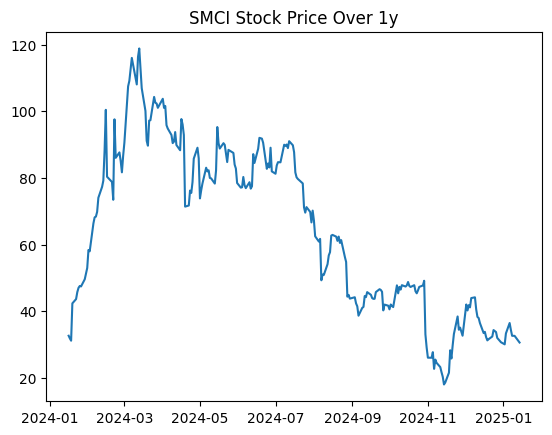

        Date       Open       High        Low      Close  Adj Close     Volume
0 2024-01-16  34.055000  35.200001  32.431000  32.631001  32.631001   47329000
1 2024-01-17  32.050999  32.200001  30.575001  31.823000  31.823000   35858000
2 2024-01-18  33.000999  33.400002  30.646999  31.143999  31.143999   48751000
3 2024-01-19  34.756001  42.868999  33.888000  42.335999  42.335999  231125000
4 2024-01-22  45.634998  48.585999  41.019001  43.624001  43.624001  188233000


In [731]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

symbol = "SMCI"
period = "1y"
df = yf.download(symbol, period = period)

df = df.reset_index()
plt.plot(df['Date'], df['Close'])
plt.title('{} Stock Price Over {}'.format(symbol, period))
plt.show()

print(df.head())

### Parameters to Control
- wick_threshold
    - English: Strength of rejection
    - What: Used to filter for strong rejection / signals 
    - How: Measure the size of a wick (in USD) to determine how "strong" a rejection signal is 
    - EX: wick_threshold = 1 would only account for wicks that are at least 1USD large (could be a very big wick or very small wick depending on price of asset - think about making this relative)
- join_level_threshold 
    - English: Leniancy of combination
    - What: threshold (in USD) in which two support/resistance levels should be combined
    - How: Check if two levels are within x USD of each other, if so, keep lower value, pop other value from list
    - EX: threshold = 5, any levels within 5USD of each other will be 'combined' (one will be kept, one will be removed) (CONSIDER: making this relative to the stock price i.e. (w/in 1% of each other, etc.))
- close_limit
    - English: Detection of signal sensitivity
    - What: range (in USD) in which a candle is considered "close" to a key level
    - How: Check 4 conditions in the CloseTo functions to see if candle is "close" to a key level
    - EX: close_limit = 1, let's consider if a candle's high is "close" to resistance... The candle high is within 1 dollar of the key level (CONSIDER: making this relative to the stock price)
- n1 & n2 
    - English: Detection of key level sensitivity
    - What: the number of candles (backward and forward respectively) of the candle of interest, used to identify local extrema (testing the candle)
    - How: if a candle within local vicinity (from l - n1 to l + n2) is a key level
    - EX: If there is a candle that has a lower low than the current candle within n1 to n2 candles around it, it can't be a local min (n1 = left preceding, n2 = right proceeding)
- n
    - English: Quick check, are candles below/above resistance/support?
    - What: Number of candles before candle of interest that are contained by a resistance/support level (testing the level)
    - How: Check highs/lows of n previous candles, are they lower than key level in question?
    - EX: n = 6, the previous 6 candles are below the resistance level being analyzed (n isn't a super impactful parameter on high-momentum stocks, lots of downtrends... therefore price of previous candles will certainly be well below resistance)
- backCandles
    - English: Timeframe to consider for a given candle
    - What: check within the last backCandles units of time for support/resistance levels
    - How: range from l - backCandles to l + n2 for defined window 
    - EX: backCandles = 100 would consider a timeframe of the last 100 days

What is difference b/w n, n1/n2, and backCandles?

- n1 and n2 are used to identify potential key levels
- n is used after a key level is identified
- backCandles is used to define the timeframe in which to consider support/resistance lines (last x days)

In [732]:
wick_threshold = 0.0001
join_level_threshold = 10
close_limit = 10
n1 = 7
n2 = 7
n = 6
backCandles = 25

### Support and Resistance Zones

https://youtu.be/xky3ZiCsEDs

Assumptions for reversal signal (implement identification of stop hunting):
- Wick close to S/R
- Candle body contained by the S/R
- Previous candles are either fully above/below S/R

In [733]:
"""
Inputs:
    df = dataframe to evaluate for support levels
    l = index of candle of interest
    n1 = candles before candle of interest to evaluate
    n2 = candles before candle of interest to evaluate
"""

def support(df1, l, n1, n2): 

    # If there is a candle that has a lower low than the current candle within n1 to n2 candles around it, it can't be a local min
    if (df1.Low[l-n1:l].min() < df1.Low[l] or df1.Low[l+1:l+n2+1].min() < df1.Low[l] ):
        return 0

    # Calculate size of body of candle AND size of lower wick
    candle_body = abs(df1.Open[l]-df1.Close[l])
    lower_wick = min(df1.Open[l], df1.Close[l])-df1.Low[l]

    # If size of lower wick is > size of candle body... sign of a strong rejection signal
    # Further filter the size of lower wicks with the wick_threshold variable... can identify only the strongest rejections
    if (lower_wick > candle_body) and (lower_wick > wick_threshold): 
        return 1
    
    return 0

def resistance(df1, l, n1, n2): 

    # If there is a candle that has a higher high than the current candle within n1 to n2 candles around it, it can't be a local max
    if (df1.High[l-n1:l].max() > df1.High[l] or df1.High[l+1:l+n2+1].max() > df1.High[l]):
        return 0
    
    # Calculate size of body of candle AND size of lower wick
    candle_body = abs(df1.Open[l]-df1.Close[l])
    upper_wick = df1.High[l]-max(df1.Open[l], df1.Close[l])

    # If size of upper wick is > size of candle body... sign of a strong rejection signal
    # Further filter the size of upper wicks with the wick_threshold variable... can identify only the strongest rejections
    if (upper_wick > candle_body) and (upper_wick > wick_threshold) :
        return 1

    return 0

In [734]:
def closeToResistance(l, levels, lim, df):

    """
    Inputs:
        l = candle of interest (index of candle)
        levels = list of price support / resistance lines of interest
        lim = distance in which candle wick is close enough to a level
        df = dataframe of interest
    """

    # if no levels available, why look if the price is close to a level? Duh.
    if len(levels) == 0:
        return 0
    
    # c represents a condition for a price to be "close" to resistance/support
    # c1: the high wick of candle is within range of resistance (determined by lim) --> min() looks at closest resistance line of available levels
    ## this line with key, takes the minimum of levels with RESPECT to key, so it finds the level that is most applicable 
    ## (closest to the high of the candle) while also being below the passed in limit threshold (lim)
    c1 = abs(df.High[l]-min(levels, key=lambda x:abs(x-df.High[l]))) <= lim
    # c2: the body of candle is within range of resistance (determined by lim) --> min() looks at closest resistance line of available levels
    c2 = abs(max(df.Open[l],df.Close[l]) - min(levels, key=lambda x:abs(x-df.High[l]))) <= lim
    
    ### TAKE A LOOK AT THIS LINE WHEN DONE - may remove
    # c3: the body of candle is contained below resistance???
    # c3 = min(df.Open[l],df.Close[l]) < min(levels, key=lambda x:abs(x-df.High[l]))

    ### TAKE A LOOK AT THIS LINE WHEN DONE - may remove, not sure why this would be necessary
    ### if min of open and close is below resistance, then low would have to be
    # c4: wick low of candle is below resistance???
    # c4 = df.Low[l] < min(levels, key=lambda x:abs(x-df.High[l]))

    # if high wick of candle is in range of resistance OR the body of candle is within range of resistance (good for live trading when the body is the present)
    # AND the entire body of the candle is below resistance
    # AND the low of the candle is below resistance
    if( (c1 or c2) ):       # took out  and c3 and c4 
        return min(levels, key=lambda x:abs(x-df.High[l]))
    else:
        return 0
    
def closeToSupport(l, levels, lim, df):

    # if no levels available, why look if the price is close to a level? Duh.
    if len(levels)==0:
        return 0
    
    # c represents a condition for a price to be "close" to resistance/support
    c1 = abs(df.Low[l]-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    c2 = abs(min(df.Open[l],df.Close[l])-min(levels, key=lambda x:abs(x-df.Low[l])))<=lim
    # c3 = max(df.Open[l],df.Close[l])>min(levels, key=lambda x:abs(x-df.Low[l]))
    # c4 = df.High[l]>min(levels, key=lambda x:abs(x-df.Low[l]))
    if( (c1 or c2) ):       # took out  and c3 and c4 
        return min(levels, key=lambda x:abs(x-df.Low[l]))
    else:
        return 0

In [735]:
def is_below_resistance(l, n, level, df):

    """
    Inputs:
        l = index of candle of interest
        n = how many candles before candle of interest are contained by resistance/support level
        level = resistance/support level being tested
        df = df with all data
    """

    # Is the max value of the last n candles below the level being tested (contained by resistance/support)
    return df.loc[l-n:l-1, 'High'].max() < level

def is_above_support(l, n, level, df):

    # Is the min value of the last n candles below the level being tested (contained by resistance/support)
    return df.loc[l-n:l-1, 'Low'].min() > level   

In [736]:
def check_candle_signal(l, n1, n2, backCandles, df):

    """
    Inputs:
        l = index of candle of interest
        n1 = candles on left to consider
        n2 = candles on right to consider
        backCandles = number of back candles to check for if contained by same key level
        df = data
    """

    # support levels list
    ss = []
    # resistance levels list
    rr = []

    # for each candle in the vicinity of the candle of interest
    for subrow in range(l-backCandles, l-n2):
        # using funcs defined above, define support and resistance levels
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])
    
    # ----------------------------------------------------------------------
    # Keeping support/resistance levels separate

    # # keep lowest support when popping a level
    # ss.sort() 
    # for i in range(1,len(ss)):
    #     if(i>=len(ss)):
    #         break
    #     if abs(ss[i]-ss[i-1]) <= join_level_threshold: # merging close distance levels
    #         ss.pop(i)

    # # keep highest resistance when popping one
    # rr.sort(reverse=True) 
    # for i in range(1,len(rr)):
    #     if(i>=len(rr)):
    #         break
    #     if abs(rr[i]-rr[i-1]) <= join_level_threshold: # merging close distance levels
    #         rr.pop(i)

    # ----------------------------------------------------------------------
    # Joining support/resistance levels together
    rrss = rr+ss
    rrss.sort()
    for i in range(1,len(rrss)):
        if(i>=len(rrss)):
            break
        if abs(rrss[i]-rrss[i-1]) <= join_level_threshold: # merging close distance levels
            rrss.pop(i)
    
    # candle is close to resistance/support
    cR = closeToResistance(l, rrss, close_limit, df)
    cS = closeToSupport(l, rrss, close_limit, df)
    # ----------------------------------------------------------------------

    # cR = closeResistance(l, rr, 150e-5, df)
    # cS = closeSupport(l, ss, 150e-5, df)
    
    # if candle is close to resistance/support AND
    # neighboring candles are below/above key level AND
    # add other conditions as necessary 
    if (cR and is_below_resistance(l,n,cR, df)):
        return 1
    elif(cS and is_above_support(l,n,cS,df)):
        return 2
    else:
        return 0

In [737]:
from tqdm import tqdm

signal = [0 for i in range(len(df))]

for row in tqdm(range(backCandles+n1, len(df)-n2)):
    signal[row] = check_candle_signal(row, n1, n2, backCandles, df)

df["signal"] = signal

100%|██████████| 212/212 [00:00<00:00, 223.42it/s]


In [738]:
signal_df = df[(df['signal']==1) | (df['signal']==2)]
key_level_list = []

# loop through each signal and store the according key level in a list
for i in signal_df.index:
    if signal_df.loc[i, 'signal'] == 2:
        key_level_list.append(signal_df.loc[i, 'Low'])
    if signal_df.loc[i, 'signal'] == 1:
        key_level_list.append(signal_df.loc[i, 'High'])

print(signal_df.index)
print(key_level_list)
key_level_list.sort()
print(key_level_list)

Index([ 56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  75,  76,  81,  82,
        83,  84,  98, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 137,
       154, 155, 156, 163, 164, 165, 166, 167],
      dtype='int64')
[93.2020034790039, 90.19999694824219, 88.0999984741211, 87.11000061035156, 90.71900177001953, 89.4000015258789, 88.10800170898438, 89.30000305175781, 94.94100189208984, 91.74600219726562, 70.91200256347656, 76.80000305175781, 83.33899688720703, 81.1989974975586, 82.92400360107422, 95.44999694824219, 82.25399780273438, 92.68800354003906, 93.45500183105469, 91.51399993896484, 92.5999984741211, 96.33000183105469, 86.60099792480469, 81.4800033569336, 77.40699768066406, 77.83200073242188, 76.54000091552734, 72.44499969482422, 55.52399826049805, 51.349998474121094, 39.518001556396484, 41.777000427246094, 41.88800048828125, 44.599998474121094, 44.95000076293945, 46.95000076293945]
[39.518001556396484, 41.777000427246094, 41.88800048828125, 44.599998474121094, 44.95000076293

In [739]:
# Used to place points on visualization
def pointpos(x):
    if x['signal']==1:
        return x['High']+1e-4
    elif x['signal']==2:
        return x['Low']-1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [740]:
# Visualize key levels on stock chart 

dfpl = df
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.update_layout(
    autosize=False,
    width=1000,
    height=800, 
    paper_bgcolor='black',
    plot_bgcolor='black')
fig.update_xaxes(gridcolor='black')
fig.update_yaxes(gridcolor='black')
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="Signal")

for local_key_level in key_level_list:
    fig.add_hline(y = local_key_level)
fig.show()

This checks support/resistance lines of a selected candle and provides signal of that candle... could be current / useful for live 

The example below highlights the use cases of this functionality. For SMCI, 1y timeframe, candle 231 you would expect to be a potential bullish signal, but it reads 0. The conditions were not met. HOWEVER, it's clear we can still use the lines that WERE identified in the past to make informed decisions at this moment in time, regardless if conditions are met in the exact moment.

In [741]:
def check_candle_signal_plot(l, n1, n2, backCandles, df, proximity):
    ss = []
    rr = []
    for subrow in range(l-backCandles, l-n2):
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])
    
    ss.sort() #keep lowest support when popping a level
    i = 0
    while i < len(ss)-1:
        if abs(ss[i]-ss[i+1]) <= proximity:
            # ss[i] = (ss[i]+ss[i+1])/2
            # del ss[i+1]
            del ss[i+1]
        else:
            i+=1

    rr.sort(reverse=True) # keep highest resistance when popping one
    i = 0
    while i < len(rr)-1:
        if abs(rr[i]-rr[i+1]) <= proximity:
            #rr[i] = (rr[i]+rr[i+1])/2
            #del rr[i+1]
            del rr[i]
        else:
            i+=1

    dfpl=df[l-backCandles-n1:l+n2+50]
    fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

    c=0
    while (1):
        if(c>len(ss)-1 ):
            break
        fig.add_shape(type='line', x0=l-backCandles-n1, y0=ss[c],
                    x1=l,
                    y1=ss[c],
                    line=dict(color="MediumPurple",width=2), name="Support"
                    )
        c+=1

    c=0
    while (1):
        if(c>len(rr)-1 ):
            break
        fig.add_shape(type='line', x0=l-backCandles-n1, y0=rr[c],
                    x1=l,
                    y1=rr[c],
                    line=dict(color="Red",width=2), name="Resistance"
                    )
        c+=1    

    # fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
    #             marker=dict(size=5, color="MediumPurple"),
    #             name="Signal")

    fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
    
    fig.show()
 
 
    #----------------------------------------------------------------------
    cR = closeToResistance(l, rr, close_limit, dfpl)
    cS = closeToSupport(l, ss, close_limit, dfpl)
    #print(cR, is_below_resistance(l,6,cR, dfpl))
    if (cR and is_below_resistance(l,n,cR, dfpl) ):#and df.RSI[l]>65
        return 1
    elif(cS and is_above_support(l,n,cS,dfpl) ):#and df.RSI[l]<35
        return 2
    else:
        return 0

In [742]:
last_data_point = len(df) - 1

check_candle_signal_plot(last_data_point, 4,4,100,df,0.002)

0